In [37]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# --------------------------
# 1. Load Data
# --------------------------
train = pd.read_csv('../train_with_risk_score_validated.csv')
test = pd.read_csv('../test_with_risk_score_validated.csv')

# Split features and labels
X_train = train.drop(columns=['ID', 'risk_score'])
y_train = train['risk_score']
X_test = test.drop(columns=['ID', 'risk_score'])
y_test = test['risk_score']

# --------------------------
# 2. Drop Fully-NaN Columns
# --------------------------
X_train_clean = X_train.dropna(axis=1, how='all')
X_test_clean = X_test[X_train_clean.columns]  # Ensure matching columns

# --------------------------
# 3. Impute Missing Values
# --------------------------
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_clean)
X_test_imputed = imputer.transform(X_test_clean)


In [38]:
# --------------------------
# 4. Train XGBoost Regressor
# --------------------------
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model.fit(X_train_imputed, y_train)

# --------------------------
# 5. Predict and Evaluate
# --------------------------
y_pred = model.predict(X_test_imputed)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n📊 XGBoost Model Performance:")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# --------------------------
# 6. Feature Importances
# --------------------------
importances = pd.Series(model.feature_importances_, index=X_train_clean.columns)
print("\n🔥 Top 10 Most Important Features:")
print(importances.sort_values(ascending=False).head(10))



📊 XGBoost Model Performance:
RMSE: 0.434
R² Score: 0.937

🔥 Top 10 Most Important Features:
hs_hg_c_Log2              0.131578
hs_as_c_Log2              0.113940
hs_pm25abs_yr_hs_h_Log    0.083029
h_no2_ratio_preg_Log      0.081240
hs_mn_c_Log2              0.074949
hs_pfoa_c_Log2            0.069463
hs_cd_c_Log2              0.067971
hs_ndvi100_h_None         0.053201
hs_pbde47_cadj_Log2       0.052652
hs_mvpa_prd_alt_None      0.046181
dtype: float32


c:\Users\vighn\anaconda3\envs\helix_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


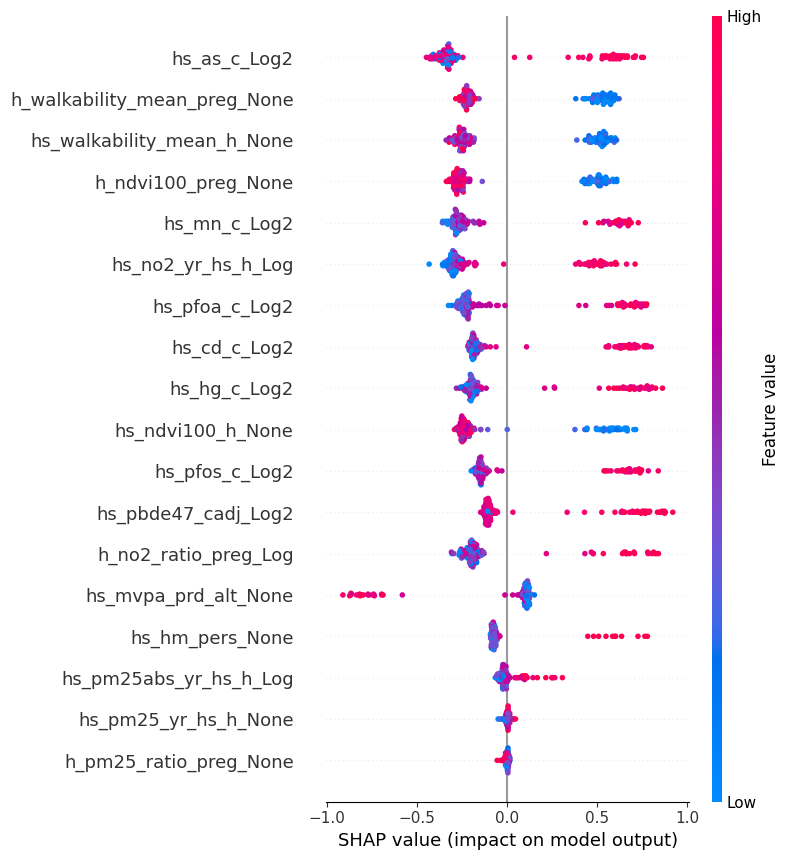

In [40]:
import shap
import matplotlib.pyplot as plt

# Explain model predictions using SHAP
explainer = shap.Explainer(model, X_train_imputed)
shap_values = explainer(X_test_imputed)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, features=X_test_imputed, feature_names=X_train_clean.columns)

# Optional: explain 1 specific prediction (e.g., test sample 0)
# shap.plots.waterfall(shap_values[0])


In [41]:
# Convert to binary classification
y_train_binary = (y_train >= 6).astype(int)
y_test_binary = (y_test >= 6).astype(int)


In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

clf.fit(X_train_imputed, y_train_binary)
y_pred_binary = clf.predict(X_test_imputed)
y_proba = clf.predict_proba(X_test_imputed)[:, 1]


c:\Users\vighn\anaconda3\envs\helix_env\lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [43]:
print("\n📊 Binary Classification Results:")
print("Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
print("Precision:", precision_score(y_test_binary, y_pred_binary))
print("Recall:", recall_score(y_test_binary, y_pred_binary))
print("ROC AUC:", roc_auc_score(y_test_binary, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test_binary, y_pred_binary))



📊 Binary Classification Results:
Accuracy: 0.8702290076335878
Precision: 0.8686868686868687
Recall: 0.9555555555555556
ROC AUC: 0.9579945799457995
Confusion Matrix:
 [[28 13]
 [ 4 86]]


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Train logistic regression on Lasso-selected features
clf_lasso = LogisticRegression(max_iter=1000)
clf_lasso.fit(X_train_selected, y_train_binary)

y_pred_lasso = clf_lasso.predict(X_test_selected)
print("Lasso-based Logistic Regression:")
print("Accuracy:", accuracy_score(y_test_binary, y_pred_lasso))
print("Precision:", precision_score(y_test_binary, y_pred_lasso))
print("Recall:", recall_score(y_test_binary, y_pred_lasso))


Lasso-based Logistic Regression:
Accuracy: 0.7786259541984732
Precision: 0.8080808080808081
Recall: 0.8888888888888888


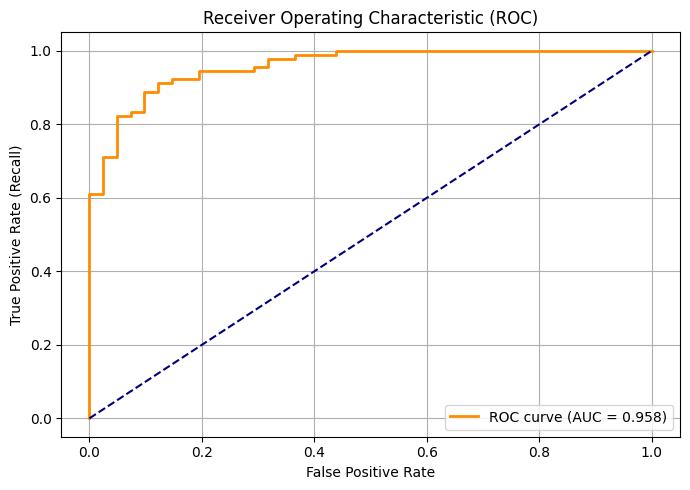

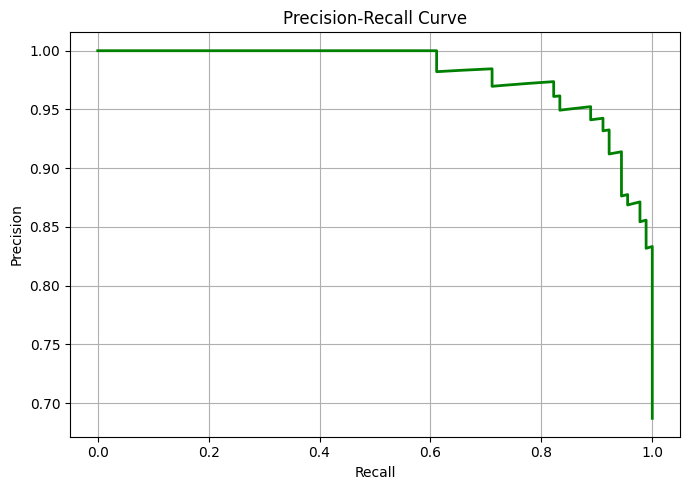

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# --------------------------
# 1. ROC Curve
# --------------------------
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# 2. Precision-Recall Curve
# --------------------------
precision, recall, _ = precision_recall_curve(y_test_binary, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()


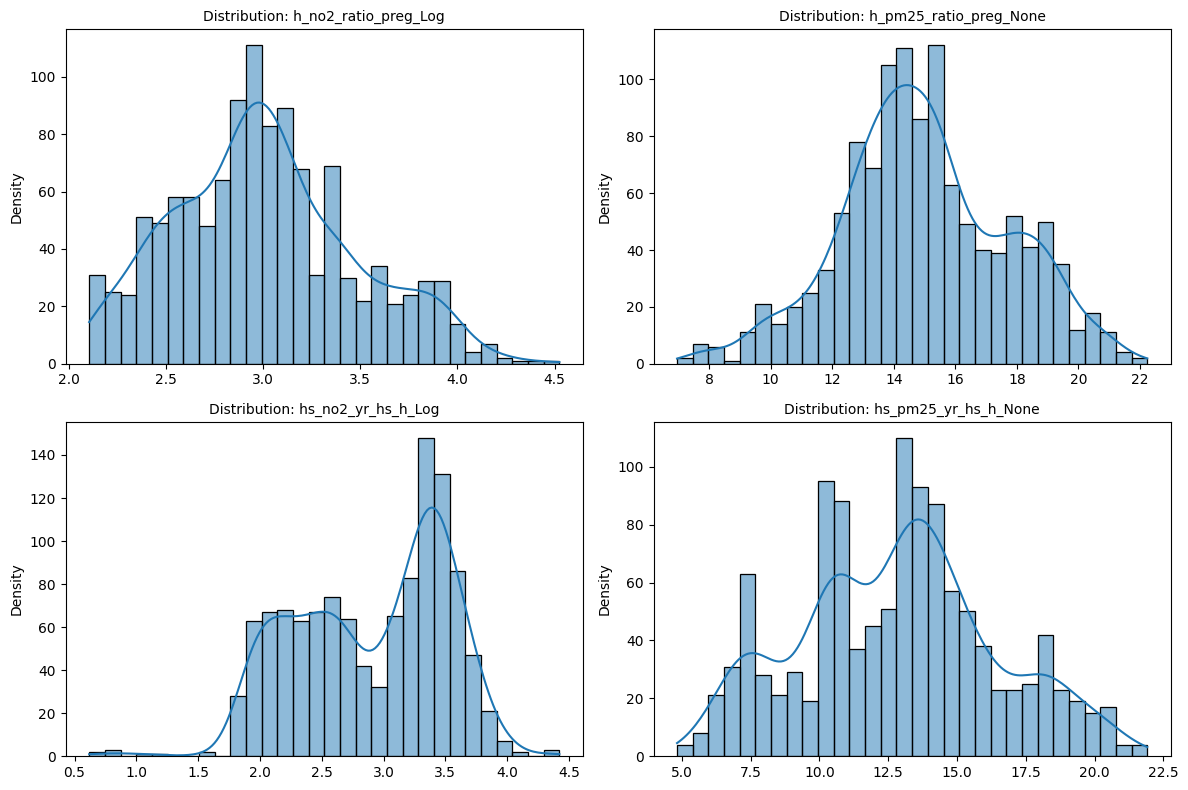

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset of actual exposure features from X_train_clean
exposure_vars = [
    'h_no2_ratio_preg_Log',
    'h_pm25_ratio_preg_None',
    'hs_no2_yr_hs_h_Log',
    'hs_pm25_yr_hs_h_None'
]

plt.figure(figsize=(12, 8))

for i, col in enumerate(exposure_vars):
    plt.subplot(2, 2, i + 1)
    sns.histplot(pd.DataFrame(X_train_clean)[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution: {col}', fontsize=10)
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.savefig('exposure_distributions.png', dpi=300)
